### Mengambil data

In [ ]:
# library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree

from sklearn.metrics import classification_report,confusion_matrix,\
                            ConfusionMatrixDisplay,roc_auc_score,\
                            recall_score, precision_score

# colors template
colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

Di bawah ini, `df1` adalah data set mengenai **performa mahasiswa** dalam kuliah, sedangkan `df2` dataset mengenai **penilaian evaluasi dosen** pemgampu matkul.

Kalau mau run ini, upload filenya ke colab dulu yak!

In [ ]:
raw_df1 = pd.read_csv('/content/Dataset1_TranscriptMahasiswa.csv', sep=';')
raw_df2 = pd.read_csv('/content/Dataset2_EvaluasiDosenPerMK.csv', sep=';')

In [ ]:
df1 = raw_df1.copy()
df2 = raw_df2.copy()

### Menampilkan data



In [ ]:
df1.shape, df2.shape

((30870, 8), (2114, 6))

In [ ]:
df1.head()

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE
0,10110310002,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,57.0,C
1,10110310002,2010,1011,EM180,EM180 Matematika Bisnis,3,70.0,B
2,10110310002,2010,1011,TI100,TI100 Algoritma dan Pemrograman,4,57.0,C
3,10110310002,2010,1011,TI101,TI101 Matematika Diskrit,3,59.0,C
4,10110310002,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B


In [ ]:
df2.head()

,TAHUN,SEMESTER,MATAKULIAH,PERTANYAAN,KETERANGAN,NILAI
0,2015,1511,IS100 Management Information Systems,1,Kesiapan memberikan perkuliahan/praktikum,"3,28"
1,2015,1511,IS100 Management Information Systems,2,Upaya menyampaikan materi perkuliahan/praktik...,"3,25"
2,2015,1511,IS100 Management Information Systems,3,Sistematis dalam menyampaikan materi perkuliah...,"3,24"
3,2015,1511,IS100 Management Information Systems,4,Kemampuan memberikan contoh yang relevan dari ...,"3,30"
4,2015,1511,IS100 Management Information Systems,5,Penyampaian materi perkuliahan sesuai dengan k...,"3,27"


In [ ]:
df1.isna().sum().sum(), df2.isna().sum().sum()

(587, 0)

In [ ]:
df1.isna().sum()

NIM           0
ANGKATAN      0
SEMESTER      0
KODE_MK       0
NAMA_MK      23
SKS           0
NILAI        12
GRADE       552
dtype: int64

In [ ]:
df1.nunique()

NIM         770
ANGKATAN      9
SEMESTER     28
KODE_MK     142
NAMA_MK     175
SKS           4
NILAI       101
GRADE        10
dtype: int64

In [ ]:
filt = (df1['KODE_MK'] == 'EM100')
df1[filt]['NAMA_MK'].value_counts()

Dasar-dasar Bisnis          202
EM100 Dasar-dasar Bisnis     53
Name: NAMA_MK, dtype: int64

**Konklusi :**

- df1 memiliki 30.000++ baris karena berisi record setiap matkul perkuliahan yang diambi setiap mahasiswa.
- df2 memiliki 2.000++ baris berisikan jawaban dari setiap pertanyaan evaluasi dosen pengampu untuk setiap matkul.
- Pada df1, ada 587 cell yang kosong dan terdapat pada kolom 'NAMA_MK', 'GRADE', dan 'NILAI'.
- Pada df2, tidak terdapat NaN.
- Penamaan matkul pada 'NAMA_MK' tidak konsisten (kadang terdapat kode matkulnya).

### Memperbaiki Data

Pada bagian ini dilakukan:
- Pembuatan kolom 'KODE_MK' pada df2
  - Hal ini dilakukan karena 'NAMA_MK' pada df1 tidak konsisten

- Konversi kolom 'NILAI' dari str menjadi float

- Imputasi NaN pada kolom 'GRADE'
  - NaN pada kolom 'NILAI' diasumsikan memiliki grade F sesuai pada tabel pada petunjuk pengerjaan

-  Menambahkan variabel 'BOBOT_NILAI' 
  - Dilihat dari 'GRADE'
  
- Menambahkan kolom 'DOSEN'
  - Diperoleh dengan menggabungkan 'SEMESTER' dengan 'KODE_MK'

#### 'KODE_MK' untuk df2

In [ ]:
df2['KODE_MK'] = df2['MATAKULIAH'].str.split(' ', expand=True)[0]

#### Konversi 'NILAI' menjadi tipe data float

In [ ]:
df2['NILAI'] = df2['NILAI'].str.split(',').apply(lambda x:int(x[0])+int(x[1])/100)

#### Mengimputasi variable 'GRADE'

In [ ]:
def GRADE_fillna(x):    # mengisi data GRADE yang hilang
  if x < 45: return 'E'
  elif x < 55: return 'D'
  elif x < 60: return 'C'
  elif x < 65: return 'C+'
  elif x < 70: return 'B-'
  elif x < 75: return 'B'
  elif x < 80: return 'B+'
  elif x < 85: return 'A-'
  elif x < 101: return 'A'
  else: return 'F'

df1['GRADE'] = df1['NILAI'].apply(GRADE_fillna)

In [ ]:
filt = df1['GRADE'].isna()
df1[filt]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE


In [ ]:
df1['NILAI'].fillna(0, inplace=True)

sudah bersih ✅

#### Menambahkan varibel 'BOBOT_NILAI'

In [ ]:
konversi_ke_bobot = dict(
    zip(['F','E','D','C','C+','B-','B','B+','A-','A'],
        [0, 0 , 1 , 2 , 2.3 , 2.7 , 3 , 3.3 , 3.7 , 4])
)

df1['BOBOT_NILAI'] = df1['GRADE'].map(konversi_ke_bobot)

#### Menambahkan kolom 'DOSEN'

In [ ]:
df1['DOSEN'] = (df1['SEMESTER'].apply(str) + '_' + df1['KODE_MK'].apply(str))
df2['DOSEN'] = (df2['SEMESTER'].apply(str) + '_' + df2['KODE_MK'].apply(str))

#### Duplikat

df2 tidak ada duplikat :

In [ ]:
dupli_cols = ['TAHUN','SEMESTER','KODE_MK','PERTANYAAN']
sum(df2.duplicated(subset=dupli_cols))

0

df1 ada dulikat :

In [ ]:
dupli_cols = ['NIM','SEMESTER', 'KODE_MK','NILAI']
sum(df1.duplicated(subset=dupli_cols))

122

Contoh baris-baris ber-duplikat:

In [ ]:

filt = (df1['NIM'] == 10110310011) & (df1['SEMESTER'] == 1011) & (df1['KODE_MK'] == 'TI110') & (df1['NILAI'] == 74.0)
df1[filt]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT_NILAI,DOSEN
353,10110310011,2010,1011,TI110,Pengantar Teknologi Multimedia,3,74.0,B,3.0,1011_TI110
354,10110310011,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B,3.0,1011_TI110


Drop duplikatnya

In [ ]:
dupli_cols = ['NIM','SEMESTER', 'KODE_MK','NILAI']
df1.drop_duplicates(subset=dupli_cols, inplace=True)

Masih ada duplikat di kolom2 ini:

In [ ]:
dupli_cols = ['NIM','SEMESTER', 'KODE_MK']
sum(df1.duplicated(subset=dupli_cols))

662

Sepertinya ini orang ngulang di semester yang sama:

In [ ]:
filt = (df1['NIM'] == 10110310011) & (df1['SEMESTER'] == 1011) & (df1['KODE_MK'] == 'EM100')
display(df1[filt])

filt = (df1['NIM'] == 10110310011) & (df1['SEMESTER'] == 1011) & (df1['KODE_MK'] == 'EM180')
display(df1[filt])

filt = (df1['NIM'] == 11110310080) & (df1['SEMESTER'] == 1321) & (df1['KODE_MK'] == 'TI751')
display(df1[filt])

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT_NILAI,DOSEN
345,10110310011,2010,1011,EM100,Dasar-dasar Bisnis,3,71.0,B,3.0,1011_EM100
346,10110310011,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,74.0,B,3.0,1011_EM100


,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT_NILAI,DOSEN
347,10110310011,2010,1011,EM180,EM180 Matematika Bisnis,3,73.0,B,3.0,1011_EM180
348,10110310011,2010,1011,EM180,Matematika Bisnis,3,74.0,B,3.0,1011_EM180


,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT_NILAI,DOSEN
6871,11110310080,2011,1321,TI751,Seminar ICT,3,87.0,A,4.0,1321_TI751
6872,11110310080,2011,1321,TI751,TI751 Seminar ICT,3,98.0,A,4.0,1321_TI751


Drop baris dengan nilai yang lebih kecil:

In [ ]:
dupli_cols = ['NIM','SEMESTER', 'KODE_MK']
temp = df1[df1.duplicated(subset=dupli_cols,keep=False)] # duplicate rows

# index nilai lebih rendah untuk di drop :
id_drop = temp.sort_values(['NIM','SEMESTER','KODE_MK','NILAI']).duplicated(subset=dupli_cols).index

df1.drop(id_drop, inplace=True)

In [ ]:
dupli_cols = ['NIM','SEMESTER', 'KODE_MK']
sum(df1.duplicated(subset=dupli_cols))

0

Gaada duplikasi ✅

#### Drop data tahun 2019

In [ ]:
df1[df1['SEMESTER'] == 1911]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT_NILAI,DOSEN
12516,13110310071,2013,1911,IS853,Magang Kerja,4,88.0,A,4.0,1911_IS853
12517,13110310071,2013,1911,SI863,Tugas Akhir,6,56.0,C,2.0,1911_SI863
18434,9318,2015,1911,SI863,Tugas Akhir,6,75.0,B+,3.3,1911_SI863
19498,10495,2015,1911,IS853,Magang Kerja,4,75.0,B+,3.3,1911_IS853
21153,11774,2015,1911,IS853,Magang Kerja,4,96.0,A,4.0,1911_IS853


Sepertinya, data untuk semester 1911 belum lengkap. Dan orang-orang pada semester sudah lebih dari 4 tahun berkuliah.
Dengan demikian, orang2 ini tidak lulus tepat waktu dan data ini tidak akan diperhatikan.

In [ ]:
id_drop = df1[df1['SEMESTER'] == 1911].index
df1.drop(id_drop, inplace=True)

#### Semester XX22

Jika seseorang mengambil semester XX22, maka tentu akan mempengaruhi perhitugan IPK. Berdasarkan keterangan yang diperoleh, IPK diperoleh dengan menghitung rata-rata keseluruhan IPS. **Jika seseorang hanya mengambil 3 SKS pada suatu semester XX22, maka hasilnya tentu akan sangat mempengaruhi IPK secara signifikan**.

\

Hal yang dapat dilakukan adalah menaruh matkul pada XX22 pada semester ganjil atau genap (XX11/XX21). Hanya saja, penempatan matkul ***tidak unik*** apakah selalu pada semester ganjil/genap.

\

Dengan demikian, kita men-drop NIM yang mengambil semester XX22.


In [ ]:
filt = df1['SEMESTER'] % 100 == 22
nim_xx22 = df1[filt]['NIM'].unique()


print(f"Banyak kolom semester XX22 : {len(df1[filt])}")
print(f"Banyak NIM (mahasiswa) mengambil semester XX22 : {df1[filt]['NIM'].nunique()}")


nim_xx22 = df1[filt]['NIM'].unique()
id_xx22 = df1[df1['NIM'].isin(nim_xx22)].index
df1.drop(id_xx22, inplace=True)

Banyak kolom semester XX22 : 409
Banyak NIM (mahasiswa) mengambil semester XX22 : 291


#### Inisiasi df3

df3 : DataFrame yang menggabungkan informasi yang diperlukan dari df1.

Fungsi di bawah akan membentuk sebuah dataframe baru df3 dengan kolom :
- 'ANGKATAN'
- 'TOTAL_TAHUN'
- 'TOTAL_SKS_GAGAL'
- 'TOTAL_SKS_LULUS'
- 'TOTAL_SKS'
- 'IPK'

In [ ]:
def func_df3(x):
  df_x = df1[df1['NIM'] == x]
  angkatan = round(df_x['ANGKATAN'].mean())
  total_sks = df_x['SKS'].sum()
  total_sks_gagal = df_x[df_x['BOBOT_NILAI'] <= 1]['SKS'].sum() # SKS D E F
  total_sks_lulus = total_sks - total_sks_gagal
  
  tahun_awal = int(str(df_x['SEMESTER'].min())[:2])
  tahun_terakhir = int(str(df_x['SEMESTER'].max())[:2])
  total_tahun = tahun_terakhir - tahun_awal + 1

  IPS = list()   # IP dalam satu semester
  for sem in df_x['SEMESTER'].unique():
    df_x_sem = df_x[df_x['SEMESTER'] == sem]
    IPS.append(sum(df_x_sem['SKS'] * df_x_sem['BOBOT_NILAI'])/sum(df_x_sem['SKS']))

  IPK = np.mean(IPS)

  return pd.Series([angkatan, total_tahun,
                    total_sks_gagal,total_sks_lulus,total_sks,
                    IPK])

DataFrame baru :

In [ ]:
df3 = pd.DataFrame(df1['NIM'].unique(), columns=['NIM'])

cols_name = ['ANGKATAN','TOTAL_TAHUN',
             'TOTAL_SKS_GAGAL','TOTAL_SKS_LULUS','TOTAL_SKS',
             'IPK']

df3[cols_name] = df3['NIM'].apply(func_df3)

In [ ]:
df3.head()

,NIM,ANGKATAN,TOTAL_TAHUN,TOTAL_SKS_GAGAL,TOTAL_SKS_LULUS,TOTAL_SKS,IPK
0,10110310005,2010.0,4.0,0.0,145.0,145.0,3.728022
1,10110310006,2010.0,4.0,2.0,143.0,145.0,3.073260
2,10110310007,2010.0,4.0,2.0,143.0,145.0,2.872892
3,10110310011,2010.0,4.0,0.0,25.0,25.0,3.208333
4,10110310015,2010.0,4.0,0.0,145.0,145.0,3.079212


In [ ]:
print('Pesebaran Total Tahun mahasiswa:')
print('-'*30)
print('Tahun  Banyak Mahasiswa')
df3['TOTAL_TAHUN'].value_counts().sort_index()

Pesebaran Total Tahun mahasiswa:
------------------------------
Tahun  Banyak Mahasiswa


1.0    142
2.0     47
3.0     23
4.0    209
5.0     52
6.0      4
7.0      2
Name: TOTAL_TAHUN, dtype: int64

#### Inisiasi df4

df4 merupakan pengembangan dari df2 dengan kolom 
- 'DOSEN',
- 'SEMESTER',
- 'KODE_MK', dan 
- 'PERTANYAAN_X', yaitu hasil evaluasi dosen pengampu suatu matkul.

In [ ]:
# Kolom Dosen
df4 = pd.DataFrame((df2['SEMESTER'].apply(str) + '_' + df2['KODE_MK'].apply(str)).unique(),
                   columns=['DOSEN'])

# Kolom Semester dan Kode MK
df4 = df4.join(df4['DOSEN'].str.split('_',expand=True
                                      ).rename(columns = {0:'SEMESTER',1:'KODE_MK'}))

# Membuat kolom Pertanyaan
n = df2['PERTANYAAN'].nunique()
for i in range(1,n+1):
  df4['PERTANYAAN_'+str(i)] = i

# Mengisi nilai dari kolom 'PERTANYAAN_X'
for i in range(len(df4)):
  for j in range(1,n+1):

    filt = (df2['DOSEN'] == df4.loc[i]['DOSEN']) & (df2['PERTANYAAN'] == j)
    df4.loc[i,'PERTANYAAN_'+str(j)] = df2[filt]['NILAI'].values


# df4.set_index('DOSEN', inplace=True)

In [ ]:
df4.head()

,DOSEN,SEMESTER,KODE_MK,PERTANYAAN_1,PERTANYAAN_2,PERTANYAAN_3,PERTANYAAN_4,PERTANYAAN_5,PERTANYAAN_6,PERTANYAAN_7,PERTANYAAN_8,PERTANYAAN_9,PERTANYAAN_10,PERTANYAAN_11,PERTANYAAN_12,PERTANYAAN_13,PERTANYAAN_14
0,1511_IS100,1511,IS100,3.28,3.25,3.24,3.30,3.27,3.19,3.18,3.32,3.29,3.24,3.31,3.27,3.26,3.31
1,1511_IS110,1511,IS110,3.19,2.98,3.08,3.03,3.18,3.05,2.91,3.20,3.07,3.07,2.97,3.08,3.19,3.22
2,1511_IS201,1511,IS201,3.27,3.18,3.16,3.25,3.22,3.20,3.02,3.20,3.14,3.14,2.98,3.09,3.20,3.33
3,1511_IS230,1511,IS230,3.29,3.21,3.21,3.25,3.21,3.25,3.11,3.21,3.25,3.18,3.11,3.14,3.21,3.25
4,1511_IS302,1511,IS302,3.22,3.16,3.17,3.17,3.17,3.11,3.14,3.20,3.20,3.24,3.13,3.19,3.17,3.24


### EDA

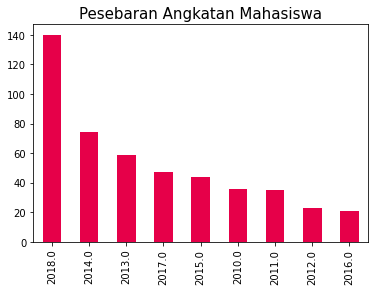

In [ ]:
df3['ANGKATAN'].value_counts().plot(kind='bar',color=colors[0])
plt.ylabel('')
plt.title('Pesebaran Angkatan Mahasiswa', fontsize=15)
plt.show()

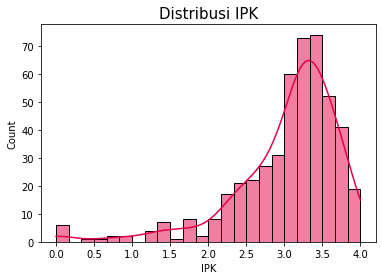

In [ ]:
sns.histplot(data=df3, x='IPK', kde=True, color=colors[0])
plt.title('Distribusi IPK', fontsize=15)
plt.show()

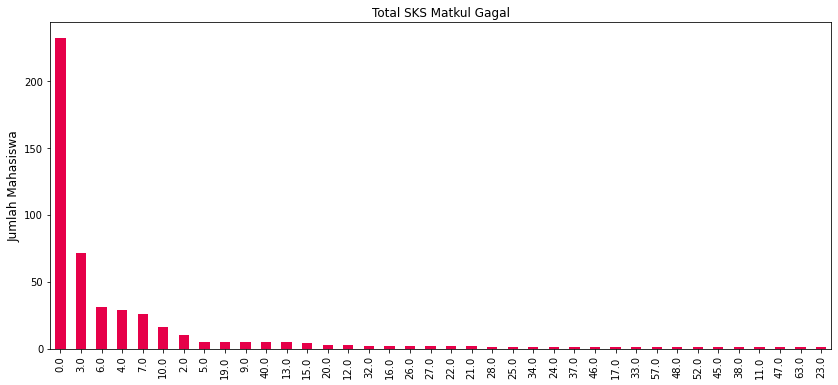

In [ ]:
plt.figure(figsize=(14,6))
df3['TOTAL_SKS_GAGAL'].value_counts().plot(kind='bar', color=colors[0])
plt.ylabel('Jumlah Mahasiswa', fontsize=12)
plt.title('Total SKS Matkul Gagal')
plt.show()

In [ ]:
df1[filt]['KODE_MK'].value_counts().sort_values()[70:]

IS230     21
CE441     22
UM223     24
IS220     25
IS110     25
IF141     29
IS201     29
IF100     30
IS240     40
IS255     93
EA100    107
Name: KODE_MK, dtype: int64

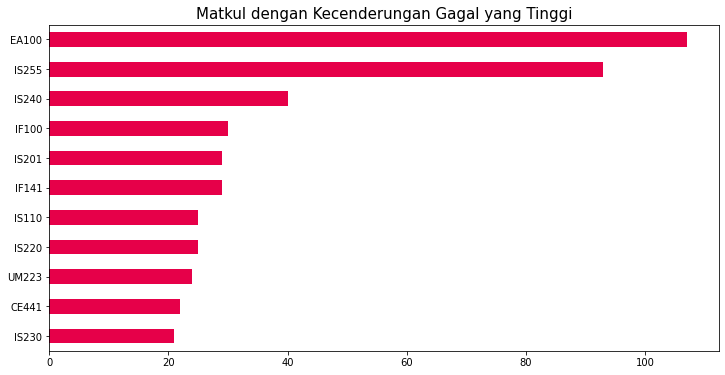

In [ ]:
plt.figure(figsize=(12,6))
filt = df1['BOBOT_NILAI'] < 2.0 # grade D ke bawah

plt.title('Matkul dengan Kecenderungan Gagal yang Tinggi', fontsize=15)
df1[filt]['KODE_MK'].value_counts().sort_values()[70:].plot(kind='barh', color=colors[0])
plt.show()

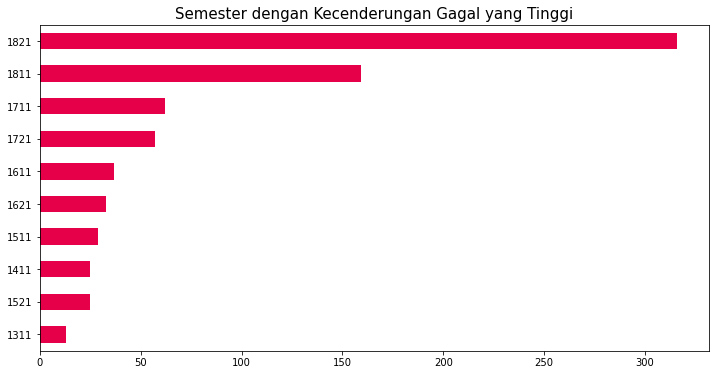

In [ ]:
plt.figure(figsize=(12,6))
filt = df1['BOBOT_NILAI'] < 2.0 # grade D ke bawah

plt.title('Semester dengan Kecenderungan Gagal yang Tinggi', fontsize=15)
df1[filt]['SEMESTER'].value_counts().sort_values()[8:].plot(kind='barh', color=colors[0])
plt.show()

### Clustering

Pertanyaan yang dianggap berpengaruh pada performa siswa adalah 2, 3, 4, 5, 9, dan 11.

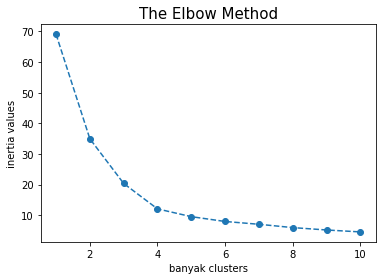

In [ ]:
inertia_values = []
cluster_cols = ['PERTANYAAN_2','PERTANYAAN_3','PERTANYAAN_4',
                'PERTANYAAN_5','PERTANYAAN_9','PERTANYAAN_11']

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    kmeans.fit(df4[cluster_cols])
    inertia_values.append(kmeans.inertia_)

# Visluasisasi Metode ELBOW untuk mendapatkan nilai optimum dari k:
plt.plot(range(1,11), inertia_values, 'o--')
plt.title('The Elbow Method', fontsize=15)
plt.xlabel('banyak clusters')
plt.ylabel('inertia values')
plt.show()

# Pilih nilai k=4 dan buat kolom kategori dosen:
kmeans = KMeans(n_clusters=4, random_state=42).fit(df4[cluster_cols])
df4['KAT_DOSEN'] = kmeans.labels_

In [ ]:
df4.head()

,DOSEN,SEMESTER,KODE_MK,PERTANYAAN_1,PERTANYAAN_2,PERTANYAAN_3,PERTANYAAN_4,PERTANYAAN_5,PERTANYAAN_6,PERTANYAAN_7,PERTANYAAN_8,PERTANYAAN_9,PERTANYAAN_10,PERTANYAAN_11,PERTANYAAN_12,PERTANYAAN_13,PERTANYAAN_14,KAT_DOSEN
0,1511_IS100,1511,IS100,3.28,3.25,3.24,3.30,3.27,3.19,3.18,3.32,3.29,3.24,3.31,3.27,3.26,3.31,0
1,1511_IS110,1511,IS110,3.19,2.98,3.08,3.03,3.18,3.05,2.91,3.20,3.07,3.07,2.97,3.08,3.19,3.22,2
2,1511_IS201,1511,IS201,3.27,3.18,3.16,3.25,3.22,3.20,3.02,3.20,3.14,3.14,2.98,3.09,3.20,3.33,2
3,1511_IS230,1511,IS230,3.29,3.21,3.21,3.25,3.21,3.25,3.11,3.21,3.25,3.18,3.11,3.14,3.21,3.25,2
4,1511_IS302,1511,IS302,3.22,3.16,3.17,3.17,3.17,3.11,3.14,3.20,3.20,3.24,3.13,3.19,3.17,3.24,2


In [ ]:
for i in range(3+1): # 2-5, 11
  dosen = df4[df4['KAT_DOSEN']==i]['DOSEN'].unique()
  print(df1[df1['DOSEN'].isin(dosen)]['NILAI'].mean())

79.98361934477379
61.1505376344086
74.63072067332983
84.85266821345708


Dosen 0 dan 3 adalah dosen bagus, dosen 1 adalah dosen jelek, dosen 2 adalah dosen biasa.

In [ ]:
df4['KAT_DOSEN'].value_counts()

0    70
2    47
3    27
1     7
Name: KAT_DOSEN, dtype: int64

### Dosen yang akan ditinjau

Tidak ada mahasiswa yang sudah menyelesaikan 144 sks dalam waktu kurang dari 4 tahun

In [ ]:
filt = (df3['TOTAL_TAHUN'] < 4) & (df3['TOTAL_SKS_LULUS'] >= 144)
df3[filt] # hasilnya kosong

,NIM,ANGKATAN,TOTAL_TAHUN,TOTAL_SKS_GAGAL,TOTAL_SKS_LULUS,TOTAL_SKS,IPK


Pembagian dataset train & test:
> train set ➡➡➡ ≥ 4 tahun (udah bisa lulus ontime) \
> test set ➡➡➡ < 4 tahun (belum bisa lulus ontime)



In [ ]:
train_df = df3[df3['TOTAL_TAHUN'] >= 4]
test_df = df3[df3['TOTAL_TAHUN'] < 4]

Pada dataset test 'test_df', terdapat paling banyak mahasiswa tahun 1 untuk diprediksi.

In [ ]:
test_df['TOTAL_TAHUN'].value_counts()

1.0    142
2.0     47
3.0     23
Name: TOTAL_TAHUN, dtype: int64

#### Melihat dataset test 'test_df'

151 dosen (yang unik) pada dosen df2.
\
ada 212 nim di test_df nantinya.
\
dosen ditinjau adalah dosen pada NIM test yang muncul lebih dari 40 kali pada mahasiswa, mempunyai evaluasi di df2.


Dosen harus terdapat pada train_df, test_df, dan evaluasi df_2.

In [ ]:
nim_train = train_df['NIM'].unique()
nim_test = test_df['NIM'].unique()

dosen_train = df1[df1['NIM'].isin(nim_train)]['DOSEN'].unique() 
dosen_test = df1[df1['NIM'].isin(nim_test)]['DOSEN'].unique() 
dosen_df2 = df2['DOSEN'].unique()


# intersections..
dosen_ditinjau = set(dosen_train).intersection(
    set(dosen_test)
)
dosen_ditinjau = dosen_ditinjau.intersection(
    set(dosen_df2)
)


dosen_ditinjau = list(dosen_ditinjau)

In [ ]:
print(f"Ada {len(dosen_ditinjau)} yang ditinjau")

print('-'*50, end='\n\n')

print('Beberapa contoh:')
dosen_ditinjau[:5]

Ada 43 yang ditinjau
--------------------------------------------------

Beberapa contoh:


['1821_IS228', '1711_IS110', '1721_IS432', '1811_IS543', '1721_IS230']

Menyingkirkan dosen biasa karena dianggap tidak akan terlalu berpengaruh pada model, yaitu  'KAT_DOSEN' == 2

In [ ]:
for dosen in dosen_ditinjau:
  if (df4.set_index('DOSEN')).loc[dosen,'KAT_DOSEN'] in [2] :
    dosen_ditinjau.remove(dosen)
    # print(dosen)

In [ ]:
len(dosen_ditinjau)

34

#### Apakah tiap semester, dosen tiap matkul selalu sama?

Di sini, dosen yang akan ditinjau adalah dosen yang selalu mengajar matkul yang sama setiap tahunnya. Indikatornya adalah rata-rata nilai mahasiswa yang tidak terlalu berubah signifikan.

In [ ]:
matkul_dosen_ditinjau = list()
for dosen in dosen_ditinjau:
  matkul_dosen_ditinjau.append(dosen.split('_')[1])


# remove duplicate
matkul_dosen_ditinjau = list(set(matkul_dosen_ditinjau))

len(matkul_dosen_ditinjau)

25

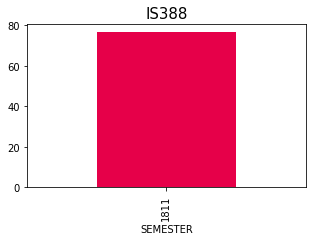

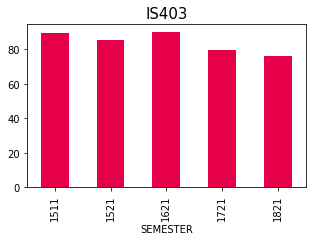

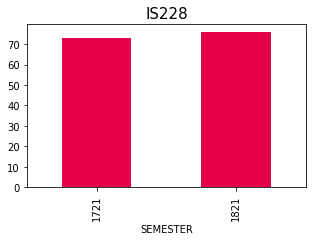

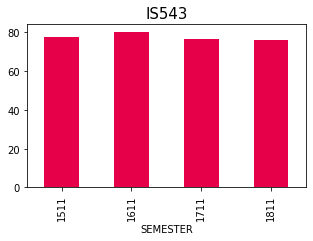

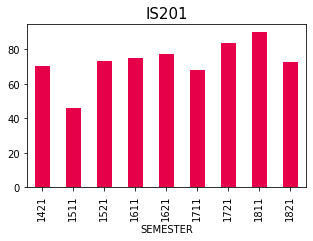

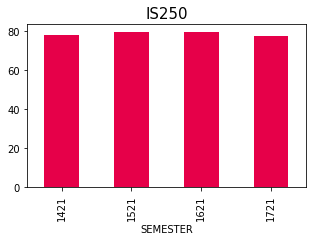

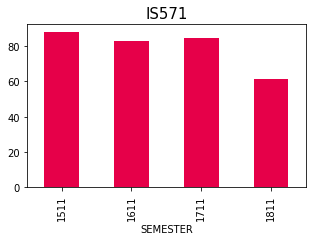

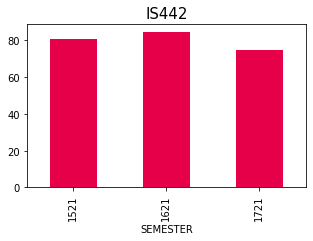

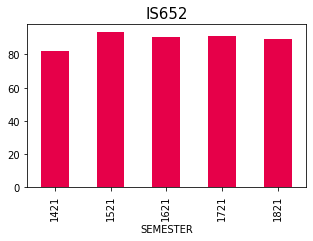

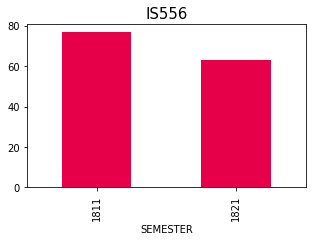

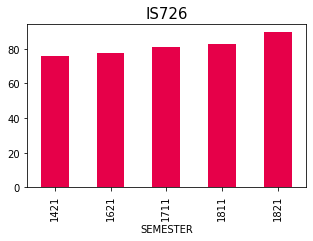

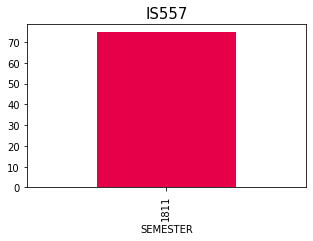

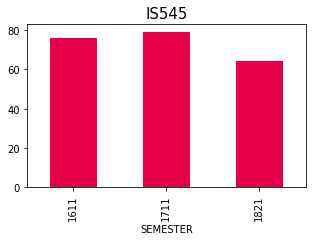

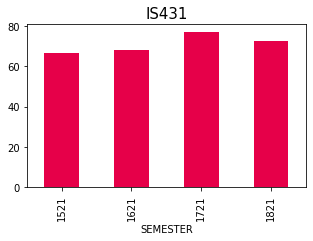

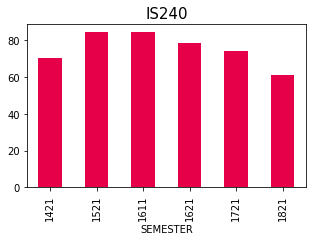

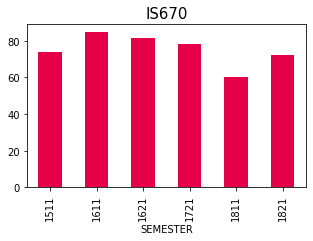

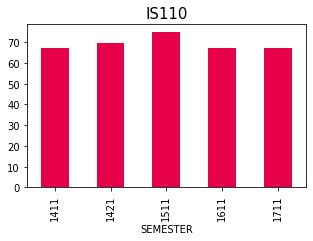

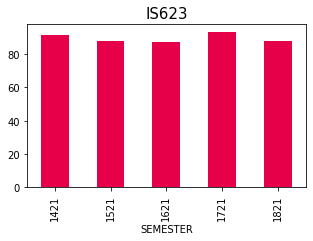

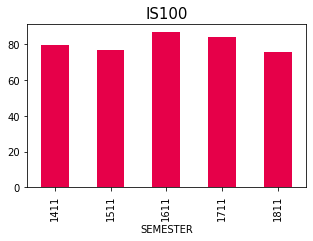

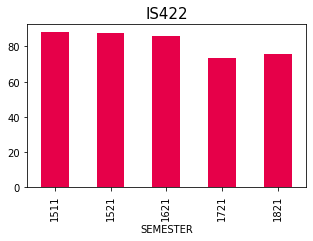

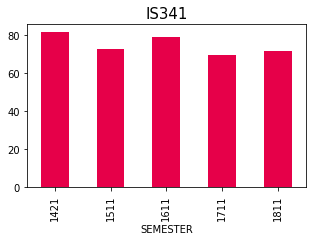

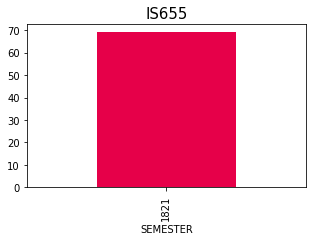

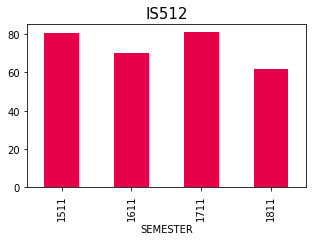

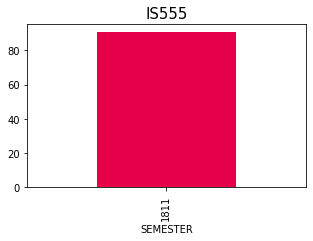

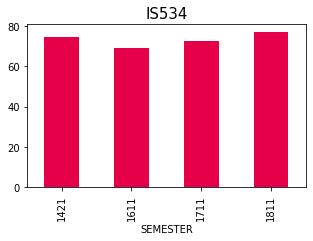

In [ ]:
for matkul in matkul_dosen_ditinjau:
  df_x = df1[df1['KODE_MK'] == matkul]

  plt.figure(figsize=(5,3))
  plt.title(matkul, fontsize=15)

  df_x.groupby('SEMESTER').mean()['NILAI'].plot(kind='bar', color=colors[0])
  plt.show()

> Yang sendiri 
- IS388
- IS557
- IS655
- IS555

> Signifikan beda:
- IS201
- IS571
- IS556
- IS545
- IS240
- IS670
- IS512 

In [ ]:
matkul_tak_pasti = ['IS388','IS557','IS655','IS555','IS201','IS571','IS556',
                    'IS545','IS240','IS670','IS512']

for matkul in matkul_tak_pasti:
  for dosen in dosen_ditinjau:
    if dosen.endswith(matkul):
      dosen_ditinjau.remove(dosen)

In [ ]:
len(dosen_ditinjau)

20

#### Dosen dihadapi di saat tahun ke berapa?

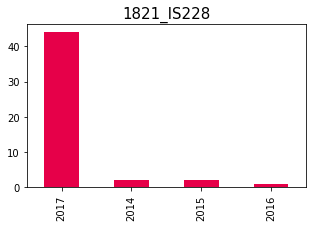

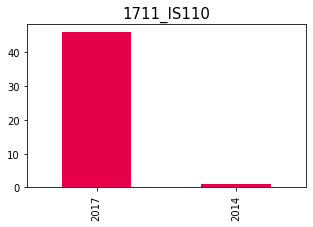

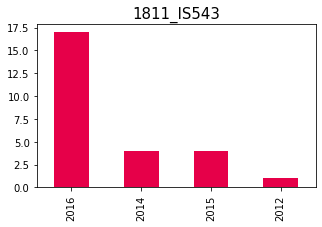

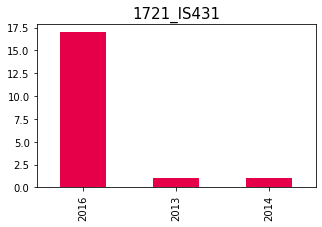

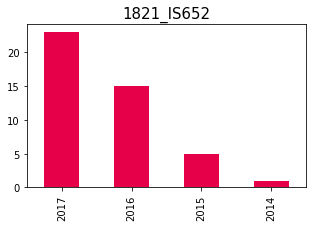

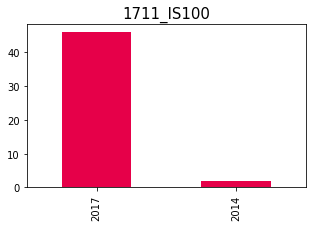

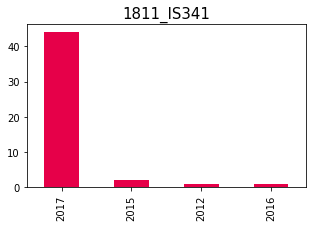

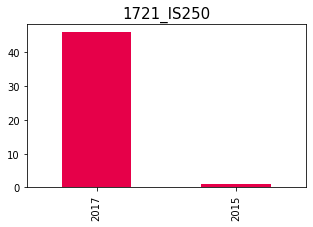

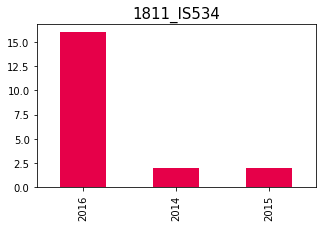

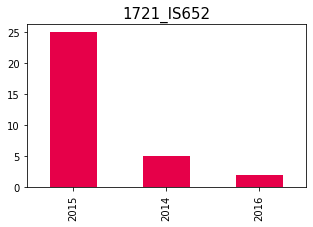

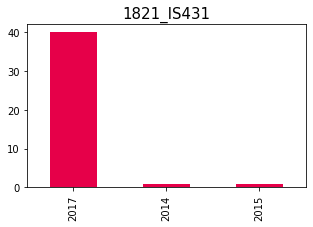

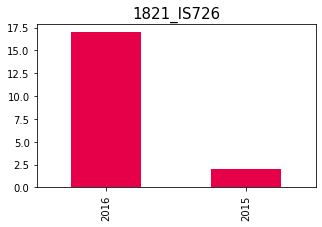

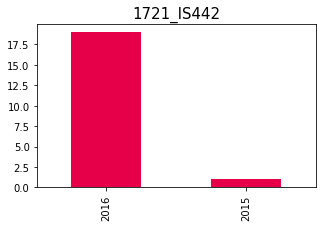

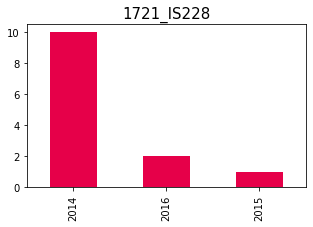

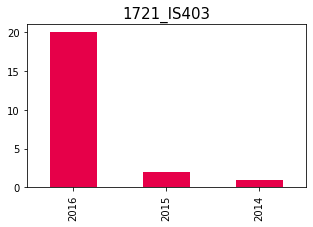

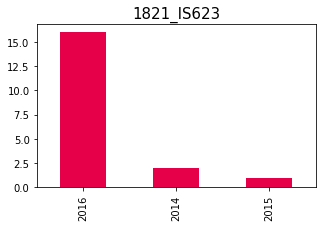

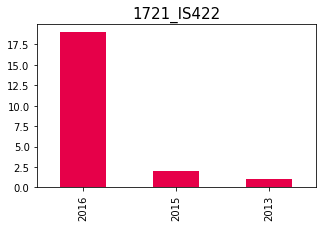

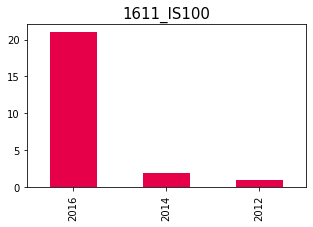

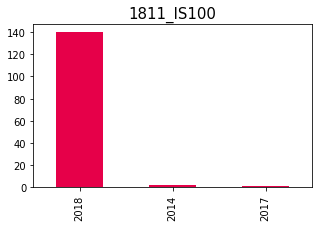

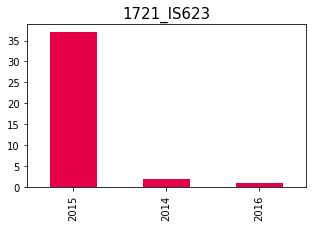

In [ ]:
for dosen in dosen_ditinjau:

  df_x = df1[df1['DOSEN'] == dosen]

  plt.figure(figsize=(5,3))
  plt.title(dosen, fontsize=15)

  df_x['ANGKATAN'].value_counts().plot(kind='bar', color=colors[0])
  plt.show()

> Kecenderungan tahun:
- Tahun 1:
  - IS110, IS100, IS250
- Tahun 2 :
  - IS228, IS431, IS1811, IS341, IS431, IS442, IS403, IS422
- Tahun 3:
  - IS534, IS652, IS726,IS623, IS543
- Tahun 4 
  - IS228

In [ ]:
for dosen in dosen_ditinjau:
    if dosen.endswith('IS228'):
      dosen_ditinjau.remove(dosen)

In [ ]:
len(dosen_ditinjau)

18

### Modifikasi pada df1 untuk train_df

Tujuannya adalah untuk mengubah train_df seperti test_df

In [ ]:
np.random.seed(42)

nim_train = df3[df3['TOTAL_TAHUN'] >= 4]['NIM'].unique()
np.random.shuffle(nim_train)

nim_train_1 = list()
nim_train_2 = list()
nim_train_3 = list()

for i in range(len(nim_train)//3):
  nim_train_1.append(nim_train[i])
for i in range(len(nim_train)//3,len(nim_train)//3*2):
  nim_train_2.append(nim_train[i])
for i in range(len(nim_train)//3*2,len(nim_train)):
  nim_train_3.append(nim_train[i])

In [ ]:
df1_mod = (df1[df1['NIM'].isin(nim_train)]).copy()
df1_mod['TAHUN-KE'] = (df1_mod['SEMESTER'].apply(lambda x:int(str(x)[:2])) - (df1_mod['ANGKATAN']-2000) +1)

In [ ]:
cond1 = (df1_mod['NIM'].isin(nim_train_1)) & (df1_mod['TAHUN-KE'] > 1)
cond2 = (df1_mod['NIM'].isin(nim_train_2)) & (df1_mod['TAHUN-KE'] > 2)
cond3 = (df1_mod['NIM'].isin(nim_train_3)) & (df1_mod['TAHUN-KE'] > 3)
filt = cond1 | cond2 | cond3
id_drop = df1_mod[filt].index

df1_mod.drop(id_drop, inplace=True)

In [ ]:
def func_df3_mod(x):
  df_x = df1_mod[df1_mod['NIM'] == x]
  angkatan = round(df_x['ANGKATAN'].mean())
  total_sks = df_x['SKS'].sum()
  total_sks_gagal = df_x[df_x['BOBOT_NILAI'] <= 1]['SKS'].sum() # SKS D E F
  total_sks_lulus = total_sks - total_sks_gagal
  
  tahun_awal = int(str(df_x['SEMESTER'].min())[:2])
  tahun_terakhir = int(str(df_x['SEMESTER'].max())[:2])
  total_tahun = tahun_terakhir - tahun_awal + 1

  IPS = list()   # IP dalam satu semester
  for sem in df_x['SEMESTER'].unique():
    df_x_sem = df_x[df_x['SEMESTER'] == sem]
    IPS.append(sum(df_x_sem['SKS'] * df_x_sem['BOBOT_NILAI'])/sum(df_x_sem['SKS']))

  IPK = np.mean(IPS)

  return pd.Series([angkatan, total_tahun,
                    total_sks_gagal,total_sks_lulus,total_sks,
                    IPK])

In [ ]:
train_df = pd.DataFrame(df1_mod['NIM'].unique(), columns=['NIM'])

cols_name = ['ANGKATAN','TOTAL_TAHUN',
             'TOTAL_SKS_GAGAL','TOTAL_SKS_LULUS','TOTAL_SKS',
             'IPK']

train_df[cols_name] = train_df['NIM'].apply(func_df3_mod)

In [ ]:
train_df['TOTAL_TAHUN'].value_counts()

1.0    90
2.0    89
3.0    88
Name: TOTAL_TAHUN, dtype: int64

### Variabel Prediktor

In [ ]:
def dosen_pred_train(x):
  df_x = df1_mod[df1_mod['NIM'] == x]

  return pd.Series(
      [int(dosen_ditinjau[i] in df_x['DOSEN'].unique()) \
       for i in range(len(dosen_ditinjau))]
  )

def dosen_pred_test(x):
  df_x = df1[df1['NIM'] == x]

  return pd.Series(
      [int(dosen_ditinjau[i] in df_x['DOSEN'].unique()) \
       for i in range(len(dosen_ditinjau))]
  )

In [ ]:
train_df[dosen_ditinjau] = train_df['NIM'].apply(dosen_pred_train)
test_df[dosen_ditinjau] = test_df['NIM'].apply(dosen_pred_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
int_cols = list(test_df.columns)
int_cols.remove('IPK')

for df_x in [train_df,test_df]:
  df_x[int_cols].astype('int32')

In [ ]:
train_df.head(2)

,NIM,ANGKATAN,TOTAL_TAHUN,TOTAL_SKS_GAGAL,TOTAL_SKS_LULUS,TOTAL_SKS,IPK,1711_IS110,1811_IS543,1721_IS431,...,1721_IS652,1821_IS431,1821_IS726,1721_IS442,1721_IS403,1821_IS623,1721_IS422,1611_IS100,1811_IS100,1721_IS623
0,10110310005,2010.0,2.0,0.0,84.0,84.0,3.678571,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10110310006,2010.0,3.0,2.0,124.0,126.0,2.841270,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Penambahan prediktor penting dalam indikator kelulusan mahasiswa, yaitu mengejar IPK di atas 2.5 pada tahun ke-4 (semester ke-8)

In [ ]:
for df_x in [train_df, test_df]:
  df_x['DIFF_IPK'] = df_x['IPK'] - 2.5
  df_x['DIFF_TAHUN'] = 4 - df_x['TOTAL_TAHUN']
  df_x['DIFF_SKS'] = 144 - df_x['TOTAL_SKS_LULUS']
  df_x['DIFF_IPK/DIFF_TAHUN'] = df_x['DIFF_IPK'] / df_x['DIFF_TAHUN']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
train_df.shape, test_df.shape

((267, 29), (212, 29))

In [ ]:
df3['LULUS_ONTIME'] = ((df3['TOTAL_TAHUN'] == 4) & (df3['TOTAL_SKS_LULUS'] >= 144) & (df3['IPK'] >= 2.50)).astype(int)
train_df['LULUS_ONTIME'] = 0

In [ ]:
for i in range(len(train_df)):

  filt = (df3['NIM'] == train_df.loc[i,'NIM'])

  train_df.loc[i,'LULUS_ONTIME'] = df3[filt]['LULUS_ONTIME'].values[0]

### Model

In [ ]:
train_df.columns

Index(['NIM', 'ANGKATAN', 'TOTAL_TAHUN', 'TOTAL_SKS_GAGAL', 'TOTAL_SKS_LULUS',
       'TOTAL_SKS', 'IPK', '1711_IS110', '1811_IS543', '1721_IS431',
       '1821_IS652', '1711_IS100', '1811_IS341', '1721_IS250', '1811_IS534',
       '1721_IS652', '1821_IS431', '1821_IS726', '1721_IS442', '1721_IS403',
       '1821_IS623', '1721_IS422', '1611_IS100', '1811_IS100', '1721_IS623',
       'DIFF_IPK', 'DIFF_TAHUN', 'DIFF_SKS', 'DIFF_IPK/DIFF_TAHUN',
       'LULUS_ONTIME'],
      dtype='object')

#### Feature Selection

In [ ]:
drop_cols = ['NIM','ANGKATAN','TOTAL_TAHUN','TOTAL_SKS','TOTAL_SKS_LULUS', 'IPK','LULUS_ONTIME']

In [ ]:
X.columns

Index(['TOTAL_SKS_GAGAL', '1711_IS110', '1811_IS543', '1721_IS431',
       '1821_IS652', '1711_IS100', '1811_IS341', '1721_IS250', '1811_IS534',
       '1721_IS652', '1821_IS431', '1821_IS726', '1721_IS442', '1721_IS403',
       '1821_IS623', '1721_IS422', '1611_IS100', '1811_IS100', '1721_IS623',
       'DIFF_IPK', 'DIFF_TAHUN', 'DIFF_SKS', 'DIFF_IPK/DIFF_TAHUN'],
      dtype='object')

In [ ]:
X = train_df.drop(drop_cols, axis=1)
y = train_df['LULUS_ONTIME']

#### Train-Test Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=42)

X_train.shape, X_val.shape

((186, 23), (81, 23))

In [ ]:
y_train.value_counts()

0    100
1     86
Name: LULUS_ONTIME, dtype: int64

#### Tree Based Model

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42) 
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_val)

              precision    recall  f1-score   support

           0       0.69      0.83      0.75        35
           1       0.85      0.72      0.78        46

    accuracy                           0.77        81
   macro avg       0.77      0.77      0.76        81
weighted avg       0.78      0.77      0.77        81

[[29  6]
 [13 33]]


recall score	: 0.717391304347826
precision score	: 0.8461538461538461
roc auc		: 0.7729813664596273


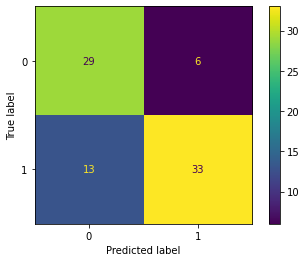

In [ ]:
print(classification_report(y_val,y_pred))

print(confusion_matrix(y_val,y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val,y_pred),
                       display_labels=tree_clf.classes_).plot()

print('\n')
print('recall score\t:',recall_score(y_val, y_pred))
print('precision score\t:', precision_score(y_val, y_pred))
print('roc auc\t\t:', roc_auc_score(y_val, y_pred))

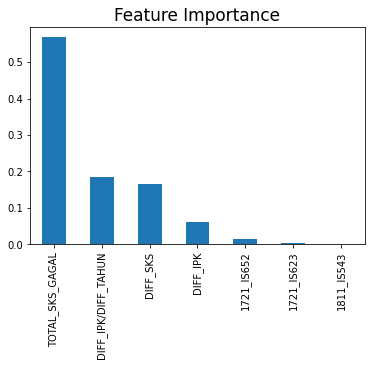

In [ ]:
pd.Series(tree_clf.feature_importances_, index=tree_clf.feature_names_in_).sort_values(ascending=False)[:7].plot(kind='bar')
plt.title('Feature Importance', fontsize=17)
plt.show()

In [ ]:
str(tree_clf.classes_)

'[0 1]'

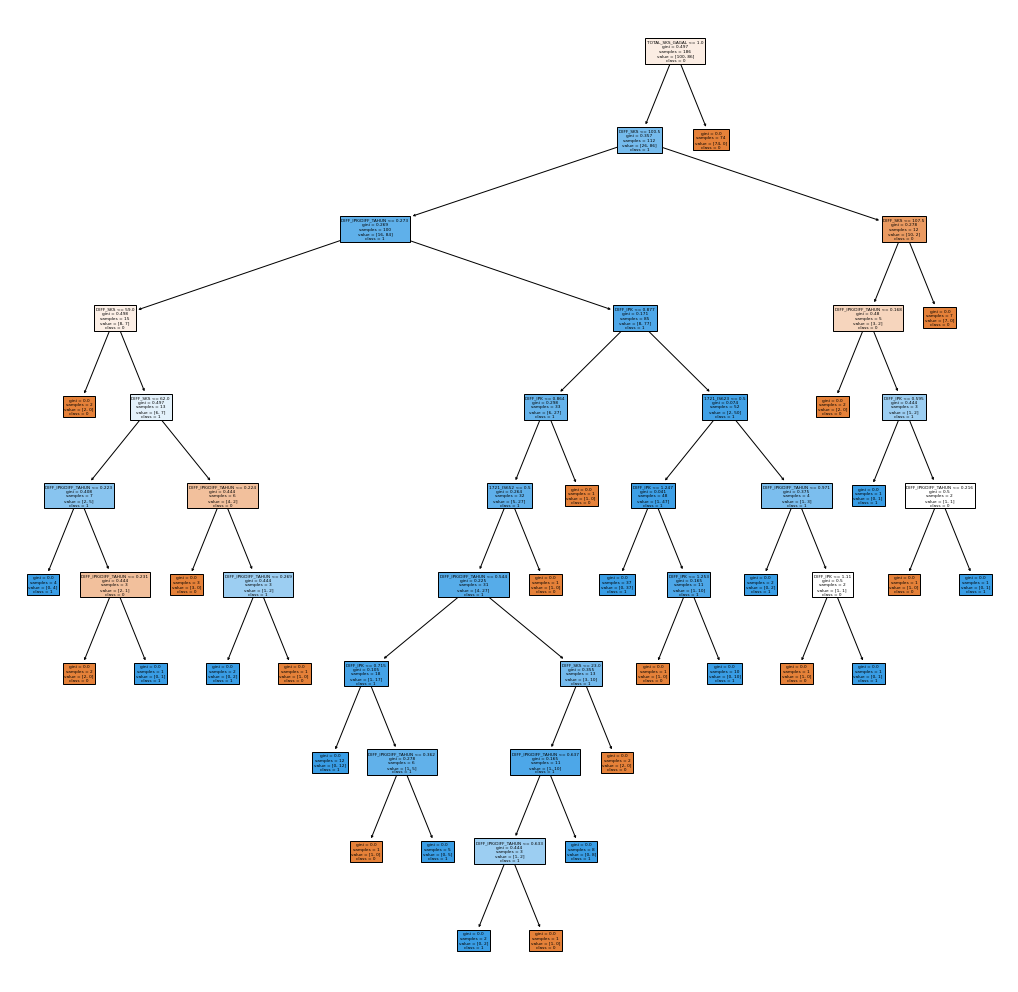

In [ ]:
plt.figure(figsize=(18,18))
plot_tree(tree_clf,filled=True,
          feature_names=tree_clf.feature_names_in_,
          class_names=["0","1"])
plt.show()

#### Prediksi

In [ ]:
drop_cols = ['NIM','ANGKATAN','TOTAL_TAHUN','TOTAL_SKS','TOTAL_SKS_LULUS', 'IPK']
prediction_ontime = tree_clf.predict(test_df.drop(drop_cols,axis=1))

In [ ]:
test_df['PREDICTION'] = prediction_ontime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df['PREDICTION'].value_counts()

0    154
1     58
Name: PREDICTION, dtype: int64

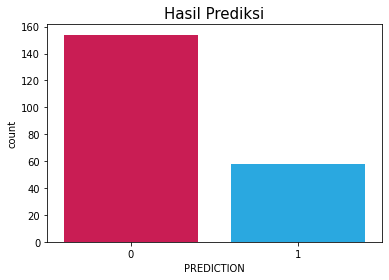

In [ ]:
sns.countplot(data=test_df, x='PREDICTION', palette=colors)
plt.title('Hasil Prediksi', fontsize=15)
plt.show()